In [2]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple

Node = Tuple[int, int]

In [3]:
def manhattan_distance(node1: Node, node2: Node) -> float:
    return abs(node1[0] - node2[0]) + abs(node1[1] - node2[1])


class LatticeDistance:

    def __init__(self, n: int) -> None:
        self.n = n

    def __call__(self, node1: Node, node2: Node) -> float:
        dx = abs(node1[0] - node2[0])
        dy = abs(node1[1] - node2[1])
        if dx > self.n / 2:
            dx = self.n - dx
        if dy > self.n / 2:
            dy = self.n - dy
        return dx + dy

def euclidean_distance(node1: Node, node2: Node) -> float:
    return ((node1[0] - node2[0])**2 + (node1[1] - node2[1])**2)**0.5

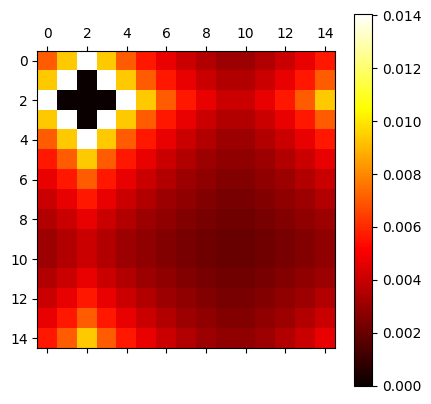

In [94]:
def offset_proba_mtx(n: int, node: Node, alpha: float) -> np.ndarray:
    mtx = np.zeros((n, n))
    ld = LatticeDistance(n)
    for i in range(n):
        for j in range(n):
            if ld(node, (i, j)) < 2:
                continue
            mtx[i, j] = ld(node, (i, j))**-alpha
    mtx /= mtx.sum()
    return mtx


ALPHA = 1

N = 15
X, Y = 2, 2
m = offset_proba_mtx(N, (X, Y), ALPHA)
plt.matshow(m, cmap='hot')
plt.colorbar()

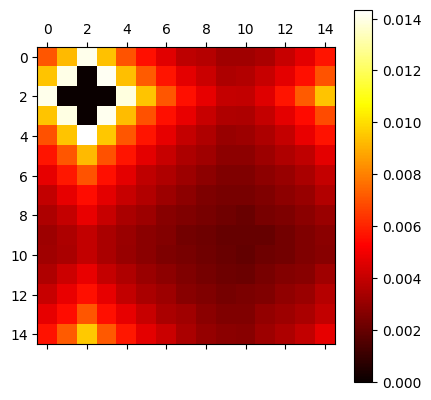

In [95]:
N_SAMPLES = 1000000
probas = m.reshape(-1)
samples = np.random.choice(np.arange(N**2), size=N_SAMPLES, p=probas)
x = samples // N
y = samples % N
empirical = np.zeros((N, N))
for i in range(N_SAMPLES):
    empirical[x[i], y[i]] += 1
empirical /= empirical.sum()
plt.matshow(empirical, cmap='hot')
plt.colorbar()

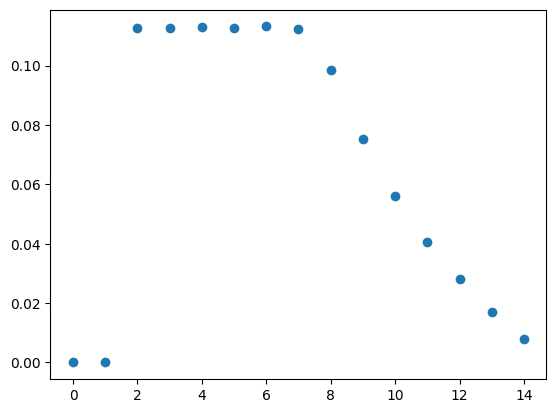

In [102]:
ld = LatticeDistance(N)
empirical_distances = {}
for i in range(N):
    for j in range(N):
        dist = ld((X, Y), (i, j))
        if dist not in empirical_distances:
            empirical_distances[dist] = 0
        empirical_distances[dist] += empirical[i, j]
plt.scatter(empirical_distances.keys(), empirical_distances.values())

Counter({8: 28, 7: 28, 9: 24, 6: 24, 10: 20, 5: 20, 11: 16, 4: 16, 12: 12, 3: 12, 2: 8, 13: 8, 1: 4, 14: 4, 0: 1})


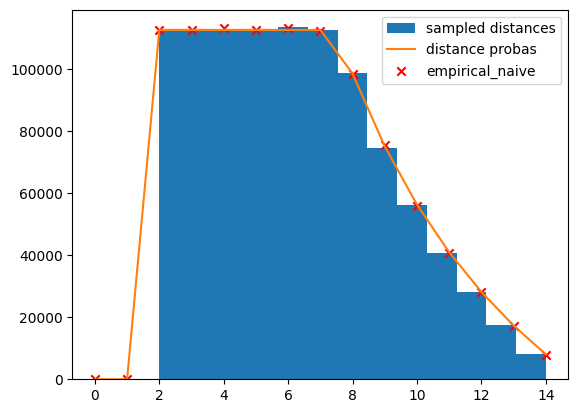

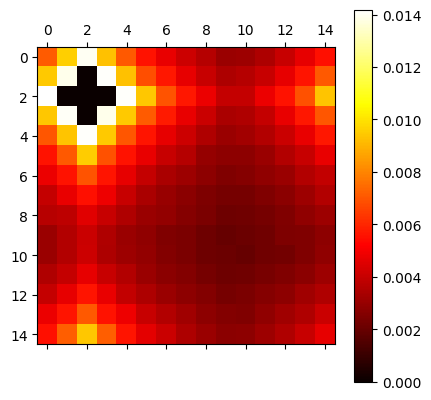

In [103]:
from collections import Counter
import random
# smart sampling
max_dist = 14
distance_probas = np.array([0] + [i**-ALPHA for i in range(1, max_dist+1)])
distance_probas[1] = 0
distance_mtx = np.zeros((N, N))
for i in range(N):
    for j in range(N):
        distance_mtx[i, j] = ld((5, 7), (i, j))

num_occurrences = Counter(distance_mtx.astype(int).flatten())
print(num_occurrences)
for k, v in num_occurrences.items():
    distance_probas[k] *= v
distance_probas /= distance_probas.sum()

distances = np.random.choice(np.arange(len(distance_probas)), size=N_SAMPLES, p=distance_probas)
plt.hist(distances, bins=len(distance_probas)-2, label="sampled distances")
plt.plot(distance_probas * N_SAMPLES, label="distance probas")
plt.scatter(empirical_distances.keys(), np.array(list(empirical_distances.values())) * N_SAMPLES, c="red", marker="x", label="empirical_naive")
plt.legend()
plt.show()

# based on distance, we need to count how many different offsets with that distance we have
# then sample uniformly from those offsets
deltas = [random.choice(possible_offsets(N, i)) for i in distances]
dx = np.array([d[0] for d in deltas])
dy = np.array([d[1] for d in deltas])

x = (X + dx) % N
y = (Y + dy) % N
empirical2 = np.zeros((N, N))
for i in range(N_SAMPLES):
    empirical2[x[i], y[i]] += 1
empirical2 /= empirical2.sum()
plt.matshow(empirical2, cmap='hot')
plt.colorbar()

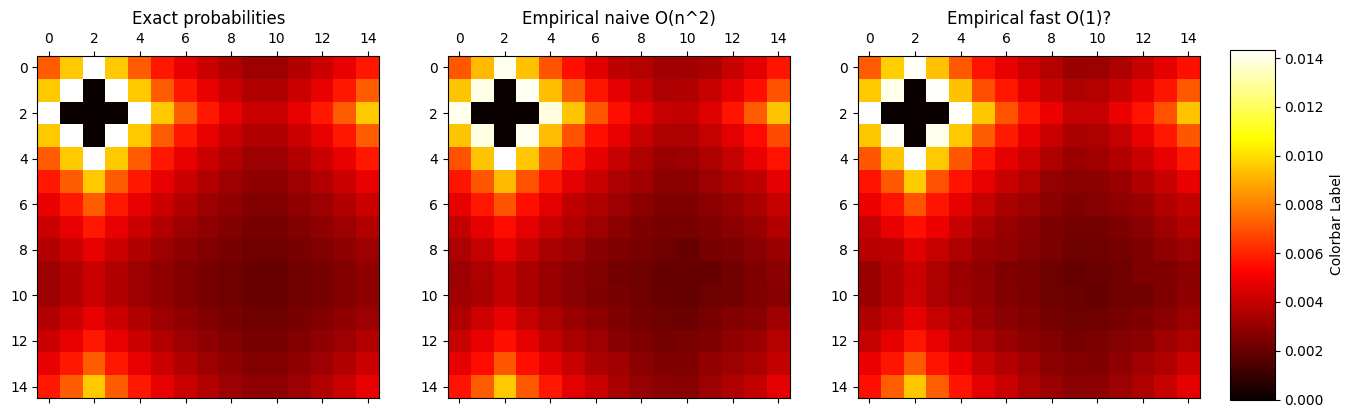

In [104]:
# common figure of exact and empirical matrices
from matplotlib.colors import Normalize
from matplotlib.colorbar import ColorbarBase


fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].matshow(m, cmap='hot')
axs[0].set_title("Exact probabilities")
axs[1].matshow(empirical, cmap='hot')
axs[1].set_title("Empirical naive O(n^2)")
axs[2].matshow(empirical2, cmap='hot')
axs[2].set_title("Empirical fast O(1)?")

vmin = min(m.min(), empirical.min(), empirical2.min())
vmax = max(m.max(), empirical.max(), empirical2.max())

# Create a normalization instance
norm = Normalize(vmin=vmin, vmax=vmax)

# Create a colorbar axes
cax = fig.add_axes([0.92, 0.15, 0.03, 0.7])  # Adjust position and size as needed

# Create the colorbar
cb = ColorbarBase(cax, cmap='hot', norm=norm)

# Add label to the colorbar if needed
cb.set_label('Colorbar Label')

plt.show()
plt.show()

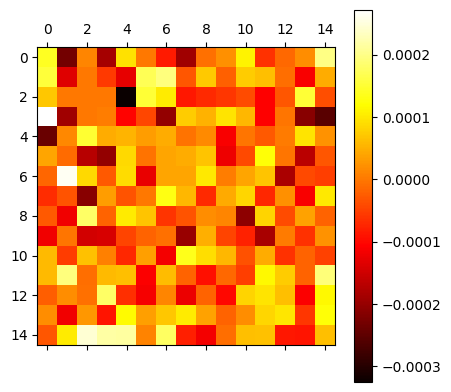

In [100]:
plt.matshow(empirical - empirical2, cmap='hot')
plt.colorbar()